# Discussion 5

### Due Friday Feb 7, 11:59:59PM


---

## Lecture Review

In [1]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import disc05 as disc

# Lecture Review: Missing Data

### Understanding Why Our Data are Missing

It is important to assess why our data are missing, as the observed data may not be representative of the complete dataset, nor the process that generated it. This limits the ability to draw conclusions about the process from the dataset.

#### Conditionally Ignorable / Missing at Random (MAR)

* Missing at Random means that the tendency for a data point to be missing *explainable* by some of the observed data.
    * Whether or not someone answered #1351 on your survey has nothing to do with the missing value (what the answer would've been), but it does have to do with the values of some other variable (e.g. whether it came near the beginning or end of a very long survey).
    * Think of this as (Conditionally) Missing at Random because the missingness is conditional on another observed variable.  
    * The idea is, if we can control for this conditional variable, we can get an unconditional random subset.
    
$$Pr({\rm data\ is\ present\ } | Y_{obs}, Y_{mis}, \psi) = Pr({\rm data\ is\ present\ } |\ Y_{obs}, \psi)$$

#### Unconditionally Ignorable / Missing Completely at Random (MCAR)

* The fact that a certain value is missing has nothing to do with its hypothetical value and with the values of other variables.
    * There is no relationship between whether a data point is missing and any values in the data set, missing or observed.

    * The missing data are just a random subset of the data.
    
$$Pr({\rm data\ is\ present\ } | Y_{obs}, Y_{mis}, \psi) = Pr({\rm data\ is\ present\ } |\ \psi)$$

#### Non-Ignorable / Missing Not at Random (NMAR)

* The missing value depends on the hypothetical (unobserved) value itself and isn't the tendency to be missing is'not explainable by any other data. 
    * e.g. People with high salaries generally do not want to reveal their incomes in surveys.
* Because non-ignorable missing data depends on the values of the unobserved data, you cannot determine it from the data alone! It is an assumption on the data generating process.
* If the you can add more attributes that 'explain' the missingness, non-ignorable data can become ignorable.
    * e.g. Adding Education level and zip code may explain the non-response of people with high-salaries.
    
$$Pr({\rm data\ is\ present\ }| Y_{obs}, Y_{mis}, \psi)$$

### Determining Missingness Types

Determining the mechanisms of missingness involves *searching for patterns to explain how data are missing*. When assessing a dataset:
1. In what ways might the missing values in a dataset come to be missing? Try to come up with explanations involving the data generating process. If you arrive at reasons for missingness that are not explainable by the dataset, then you have identified *non-ignorable* missing data. If this is the case, can you think attributes to collect that might explain the missing data?
1. Once you believe that patterns in the missingness of an attribute are explainable by the observed data, you can try to determine the nature of these patterns. In this case, look at the data when the attribute in question is missing, versus when it's not missing: do the data look the the same in both cases? To do this:
    - Consider the `missing` and `not_missing` data as two groups, and compare the distributions of the other attributes to determine if they look similar.
    - To determine the similarity of the two distributions, use a permutation test.
1. If the two distributions are different, then you've identified a pattern in the missingness: the likelihood the attribute is missing depends on the values of another attribute in the dataset (it's conditional on the other attribute).
1. If there are no patterns in the missingness of the data, then the dataset is *unconditionally ignorable*.

### Examples: Salaries

Below are the salaries of San Diego city employees, with missing data. Assuming that this data was collected via a survey given at work. (In reality, this dataset is a *census*, including every employees salaries).

**Question:** What are some potential explanations for why salary data might be missing from this dataset? What are potential fields that could be collected to explain the missingness?

In [4]:
salaries1 = pd.read_csv('data/salaries_miss1.csv')
salaries2 = pd.read_csv('data/salaries_miss2.csv')
salaries1[['Total Pay']].head(7)

,Total Pay
0,323377.0
1,NaN
2,NaN
3,NaN
4,279700.0
5,277860.0
6,NaN


Next, we'll assess whether the 'Total Pay' is missing conditional on job 'Status'.

In [5]:
df = salaries2
# df = salaries1

In [6]:
df.head()

,Total Pay,Status
0,NaN,FT
1,NaN,FT
2,NaN,FT
3,NaN,FT
4,279700.0,PT


In [7]:
df.isnull().mean().rename('proportion null').to_frame()

,proportion null
Total Pay,0.300008
Status,0.000000


Compute the empirical distribution of 'Status' conditional on missingness of 'Total Pay'. Do these distributions look similar?

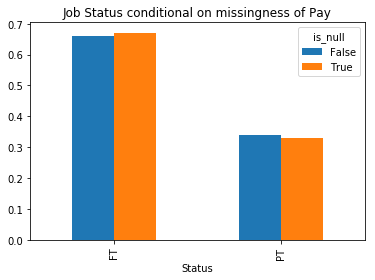

In [8]:
distr = (
    df
    .assign(is_null=df['Total Pay'].isnull())
    .pivot_table(index='Status', columns='is_null', aggfunc='size')
    .apply(lambda x:x/x.sum())
)

distr.plot(kind='bar', title='Job Status conditional on missingness of Pay');

In [9]:
distr

is_null,False,True
Status,,
FT,0.661063,0.670758
PT,0.338937,0.329242


Is this difference between the distributions due to chance? Or are the distributions significantly different?

1. Measure similarity between the *observed* distributions with the TVD.
1. Run a permutation test to assess the magnitude of the observed statistic. Repeatedly:
    - The two groups are *missing pay* and *not missing pay*.
    - Shuffle the labels, separate the shuffled groups into 'random groups'.
    - Calculate the tvd of the random groups.
1. The distribution of the 'shuffled TVDs' is the null distribution. How likely was the observed TVD generated from the null distribution? Calculate a p-value!


In [10]:
# observed TVD
obs = distr.diff(axis=1).abs().iloc[:,-1].sum() / 2
obs

0.009694272622928934

In [11]:
# Shuffle once
(
    df
    .assign(is_null=df['Total Pay'].isnull())  # create label column
    .assign(Status=df['Total Pay'].sample(frac=1, replace=False).reset_index(drop=True)) # shuffle 'total pay' -- same effect as shuffling label
    .pivot_table(index='Status', columns='is_null', aggfunc='size')  # compute counts for the conditional distribution
    .apply(lambda x:x/x.sum())  # normalize counts to a distribution
    .diff(axis=1).abs().iloc[:,-1].sum() / 2    # calculate the TVD of the shuffled distributions
)

0.013784271438960074

In [12]:
N = 1000

tvds = []
for _ in range(N):
    shuffed = (
        df
        .assign(is_null=df['Total Pay'].isnull())
        .assign(Status=df['Total Pay'].sample(frac=1, replace=False).reset_index(drop=True))
        .pivot_table(index='Status', columns='is_null', aggfunc='size')
        .apply(lambda x:x/x.sum())
        .diff(axis=1).abs().iloc[:,-1].sum() / 2
    )
    
    tvds.append(shuffed)

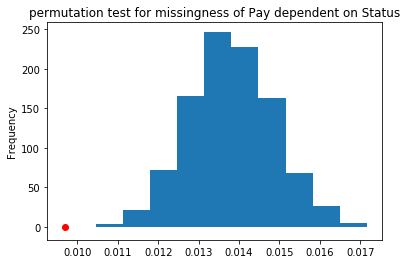

In [13]:
pd.Series(tvds).plot(kind='hist', title='permutation test for missingness of Pay dependent on Status')
plt.scatter(obs, 0, c='r');

**Question:** Does the observed dataset well-represent, over-represent, or under-represent the mean salary of city employees?

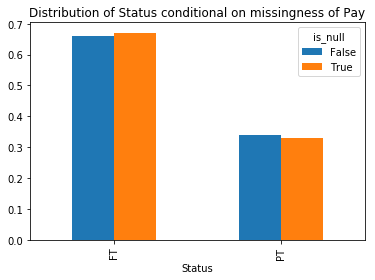

In [14]:
distr.plot(kind='bar', title='Distribution of Status conditional on missingness of Pay');

In [15]:
df['Total Pay'].mean()

64496.20434534019

**Question:** How could you estimate the mean of the population with this understanding of missingness?

Below is the population mean from the complete dataset:

In [16]:
salaries = pd.read_csv('data/salaries.csv')
salaries['Total Pay'].mean()

64984.971023773316

**Question:** What does this have to do with imputation? What if we want an imputed dataset with approximately the same mean as the population mean?

# Working with Missing Data in Pandas

* The way in which `Pandas` handles missing values is constrained by its reliance on the `NumPy` package, which does not have a built-in notion of `NaN` values for non-floating-point data types.
    * `Pandas` chose to use sentinels for missing data, and further chose to use two already-existing Python null values: the special floating-point `NaN` value, and the Python `None` object. 
    * This choice has some side effects, as we will see, but in practice ends up being a good compromise in most cases of interest.

#### `None`: Pythonic Missing Data

* The first sentinel value used by Pandas is `None`, a Python singleton object that is often used for missing data in Python code. 
    * Because it is a Python object, `None` cannot be used in any arbitrary `NumPy`/`Pandas` array, but only in arrays with data type 'object' (i.e., arrays of Python objects).

In [17]:
vals1 = np.array([1, None, 3, 4])
vals1

array([1, None, 3, 4], dtype=object)

* The use of Python objects in an array also means that if you perform aggregations like sum() or min() across an array with a None value, you will generally get an error:

In [18]:
# this reflects the fact that addition between an integer and None is undefined
vals1.sum()

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

#### `NaN`: Missing Numerical Data

* The other missing data representation, `NaN` (acronym for Not a Number), is different; it is a special floating-point value.

In [19]:
vals2 = np.array([1, np.nan, 3, 4]) 
vals2.dtype

dtype('float64')

* Notice that `NumPy` chose a native floating-point type for this array: this means that unlike the object array from before, this array supports fast operations pushed into compiled code. 
* You should be aware that `NaN` is a bit like a data virus in that it infects any other object it touches. 
    * Regardless of the operation, the result of arithmetic with `NaN` will be another `NaN`.
    * Comparisons with `NaN` always return false.
    * Use the `pd.isnull` function to check if a single value is `NaN`

In [20]:
1 + np.nan

nan

In [21]:
0 *  np.nan

nan

In [22]:
np.nan == np.nan

False

In [23]:
np.nan > 0

False

In [24]:
np.nan <= 0

False

In [25]:
pd.isnull(np.nan)

True

* This means that aggregates over the values are well defined (i.e., they don't result in an error) but not always useful.

In [26]:
vals2.sum(), vals2.min(), vals2.max()

D:\Software\Anaconda\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
D:\Software\Anaconda\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


(nan, nan, nan)

#### `NaN` and `None` in Pandas

* `NaN` and `None` both have their place, and `Pandas` is built to handle the two of them nearly interchangeably, converting between them where appropriate.

In [27]:
pd.Series([1, np.nan, 2, None])

0    1.0
1    NaN
2    2.0
3    NaN
dtype: float64

* For types that don't have an available sentinel value, Pandas automatically type-casts when NA values are present. 
    * For example, if we set a value in an integer array to `np.nan`, it will automatically be upcast to a floating-point type to accommodate the NA.

In [28]:
x = pd.Series(range(2), dtype=int)
x

0    0
1    1
dtype: int32

In [29]:
x[0] = None
x

0    NaN
1    1.0
dtype: float64

#### Applying Pandas Methods to Columns with Null Values
* Unlike `NumPy`, methods applied to Pandas Series/DataFrame usually silently apply `dropna` before applying the operation.
* Below, compare the equivalent `Pandas` and `Numpy` methods

In [30]:
df

,Total Pay,Status
0,NaN,FT
1,NaN,FT
2,NaN,FT
3,NaN,FT
4,279700.0,PT
5,277860.0,PT
6,254212.0,FT
7,246190.0,FT
8,258191.0,PT
9,NaN,FT


In [34]:
# Apply Pandas method `mean` to column  0 (a Series)
df['Total Pay'].mean()

64496.20434534019

In [35]:
# Apply Numpy method `mean` to the np.ndarray underlying column 0.
df['Total Pay'].values.mean()

nan

**Discussion Question**
* What is the output of `df[0].values.min()`?
* What is the output of  `df.min().dropna()`?

In [36]:
df
# ans1 = df[0].values.min()
# ans2 = df.min().dropna()

,Total Pay,Status
0,NaN,FT
1,NaN,FT
2,NaN,FT
3,NaN,FT
4,279700.0,PT
5,277860.0,PT
6,254212.0,FT
7,246190.0,FT
8,258191.0,PT
9,NaN,FT


#### Imputing (Filling) Null Values

* Sometimes rather than dropping NA values, we'd rather replace them with a valid value. 
* This value might be a single number like zero, or it might be some sort of imputation or interpolation from the good, non-null values. 
    * You could do this in-place using the `isnull()` method as a mask, but because it is such a common operation `Pandas` provides the `fillna()` method, which returns a copy of the array with the null values replaced.

In [37]:
data = pd.Series([1, np.nan, 2, None, 3], index=list('abcde'))
data

a    1.0
b    NaN
c    2.0
d    NaN
e    3.0
dtype: float64

In [38]:
help(data.fillna)

Help on method fillna in module pandas.core.series:

fillna(value=None, method=None, axis=None, inplace=False, limit=None, downcast=None, **kwargs) method of pandas.core.series.Series instance
    Fill NA/NaN values using the specified method
    
    Parameters
    ----------
    value : scalar, dict, Series, or DataFrame
        Value to use to fill holes (e.g. 0), alternately a
        dict/Series/DataFrame of values specifying which value to use for
        each index (for a Series) or column (for a DataFrame). (values not
        in the dict/Series/DataFrame will not be filled). This value cannot
        be a list.
    method : {'backfill', 'bfill', 'pad', 'ffill', None}, default None
        Method to use for filling holes in reindexed Series
        pad / ffill: propagate last valid observation forward to next valid
        backfill / bfill: use NEXT valid observation to fill gap
    axis : {0 or 'index'}
    inplace : boolean, default False
        If True, fill in place. Note:

In [39]:
data.fillna(0)

a    1.0
b    0.0
c    2.0
d    0.0
e    3.0
dtype: float64

In [40]:
# forward-fill
data.fillna(method='ffill')

a    1.0
b    1.0
c    2.0
d    2.0
e    3.0
dtype: float64

In [41]:
# back-fill
data.fillna(method='bfill')

a    1.0
b    2.0
c    2.0
d    3.0
e    3.0
dtype: float64

In [42]:
fill_dict = dict(zip(list('abcde'), [1, 1.5, 2, 2.5, 3]))
fill_dict

{'a': 1, 'b': 1.5, 'c': 2, 'd': 2.5, 'e': 3}

In [43]:
data.fillna(fill_dict)

a    1.0
b    1.5
c    2.0
d    2.5
e    3.0
dtype: float64

In [44]:
fill_values =  pd.Series([1, 1.5, 2, 2.5, 3], index=list('abcde'))
fill_values

a    1.0
b    1.5
c    2.0
d    2.5
e    3.0
dtype: float64

In [45]:
data.fillna(fill_values)

a    1.0
b    1.5
c    2.0
d    2.5
e    3.0
dtype: float64

* For `DataFrames`, the options are similar, but needs additional data specified:
    1. Either an axis along which the fills take place, (for `method` options).
    2. Keys for which column to which to apply each dictionary/series.

In [54]:
df = pd.DataFrame([[1, np.nan, 2, None, 3], [2, 3, 4, 5, 6], [np.nan, 1, np.nan, 2, None]], index=[1, 2, 3])
df

,0,1,2,3,4
1,1.0,NaN,2.0,NaN,3.0
2,2.0,3.0,4.0,5.0,6.0
3,NaN,1.0,NaN,2.0,NaN


In [55]:
# if a previous value is not available during a forward fill, the NA value remains
df.fillna(method='ffill', axis=1)

,0,1,2,3,4
1,1.0,1.0,2.0,2.0,3.0
2,2.0,3.0,4.0,5.0,6.0
3,NaN,1.0,1.0,2.0,2.0


In [56]:
# Fill columns 0 and 3 with column 2; Fill column 1 with [10,20,30]
fill_dict = {
    0: df[2],
    3: df[2],
    1: pd.Series({0: 10, 1: 20, 2: 30})
}
df.fillna(fill_dict)

,0,1,2,3,4
1,1.0,20.0,2.0,2.0,3.0
2,2.0,3.0,4.0,5.0,6.0
3,NaN,1.0,NaN,2.0,NaN


---
# Practice Problems

In [49]:
dg = pd.read_csv('data.csv', index_col=0)

In [36]:
dg.head()

,A,B,C,D
i0,707,0.632725,-4.188558,2.509788
i1,867,NaN,-6.206789,2.529778
i2,887,0.830099,-1.993625,1.780432
i3,651,-0.843166,-3.126965,3.149177
i4,316,0.364220,-0.047756,2.057000


In [6]:
# check the proportion of null values per column


**Question 1**

Given the dataframe `dg`, impute (i.e. fill-in) the missing values of column `B` with the value of the index for that row. To do this, write a function `impute_with_index` that takes in a dataframe `dg` and outputs the imputed column `B` (a Series).

*Remark*: can you fill in *all* the columns this way?

In [31]:
def impute_with_index(dg):
    """
    impute (i.e. fill-in) the missing values of column B 
    with the value of the index for that row.

    :Example:
    >>> dg = pd.read_csv('data.csv', index_col=0)
    >>> out = impute_with_index(dg)
    >>> isinstance(out, pd.Series)
    True
    >>> out.isnull().sum() == 0
    True
    """
    values = dict(zip(dg.index, dg.index))
    dg['B'] = dg['B'].fillna(value=values)
    return dg['B']

In [32]:
impute_with_index(dg)

i0       0.632725
i1             i1
i2       0.830099
i3      -0.843166
i4        0.36422
i5        1.53388
i6      0.0529891
i7       0.443553
i8       0.495658
i9       0.914601
i10     -0.517685
i11     0.0324545
i12     -0.353211
i13     -0.262073
i14      -1.18548
i15     -0.696169
i16      -0.78249
i17       -0.8815
i18     -0.160056
i19           i19
i20     -0.443196
i21       1.61462
i22      -0.77541
i23       1.15838
i24      0.496839
i25      -1.28295
i26      0.862969
i27     -0.662948
i28     -0.819233
i29      0.657172
          ...    
i270     -1.76177
i271     0.294565
i272    -0.804699
i273       2.4176
i274     0.933789
i275    -0.468926
i276     0.505713
i277    -0.881795
i278     0.266115
i279      0.90195
i280    -0.420918
i281    -0.878608
i282     -0.17001
i283    -0.156582
i284    -0.643518
i285         i285
i286     0.129282
i287         i287
i288     -1.27263
i289         i289
i290     -1.75239
i291      1.10527
i292         i292
i293    -0.598669
i294      

**Question 2**

Given the dataframe `dg`, impute (i.e. fill-in) the missing values of each column using the last digit of the value of column `A`. For example, if a missing value for a given row has value 78 in column `A`, then fill in the missing value with the number 8.

Write your answer as a function `impute_with_digit` that takes in a dataframe `dg` and outputs the imputed dataframe.

In [75]:
def impute_with_digit(dg):
    """
    impute (i.e. fill-in) the missing values of each column 
    using the last digit of the value of column A.

    :Example:
    >>> dg = pd.read_csv('data.csv', index_col=0)
    >>> out = impute_with_digit(dg)
    >>> isinstance(out, pd.DataFrame)
    True
    >>> out.isnull().sum().sum() == 0
    True
    """
    values = dict(zip(dg.index, dg['A'] % 10))
    for col in dg.columns:
        dg[col].fillna(value=dg['A'] % 10, inplace=True, axis=0)
    return dg

In [76]:
impute_with_digit(dg)

,A,B,C,D
i0,707,0.632725,-4.188558,2.509788
i1,867,7.000000,-6.206789,2.529778
i2,887,0.830099,-1.993625,1.780432
i3,651,-0.843166,-3.126965,3.149177
i4,316,0.364220,-0.047756,2.057000
i5,269,1.533876,-1.522245,-3.460620
i6,782,0.052989,1.137432,0.343025
i7,370,0.443553,0.000000,1.493170
i8,609,0.495658,-0.306286,0.784517
i9,599,0.914601,-3.990673,-0.665660


In [70]:
values = dict(zip(dg.index, dg['A'] % 10))
dg.fillna(dg['A'] % 10, axis=0)
dg

,A,B,C,D
i0,707,0.632725,-4.188558,2.509788
i1,867,NaN,-6.206789,2.529778
i2,887,0.830099,-1.993625,1.780432
i3,651,-0.843166,-3.126965,3.149177
i4,316,0.364220,-0.047756,2.057000
i5,269,1.533876,-1.522245,-3.460620
i6,782,0.052989,1.137432,0.343025
i7,370,0.443553,NaN,1.493170
i8,609,0.495658,-0.306286,0.784517
i9,599,0.914601,-3.990673,-0.665660
